In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from matplotlib import cm

In [40]:
df = pd.read_csv('vgsales/vgsales.csv')


In [41]:
print("Initial shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Initial shape: (16598, 11)

First 5 rows:


Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37


Data types:
Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object

Missing values:
Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


In [42]:
df['Year'] = df['Year'].fillna(0).astype(int)
df['Year'] = df['Year'].replace(0, np.nan)

df['Publisher'] = df['Publisher'].fillna('Unknown')

print("\nNumber of duplicates:", df.duplicated().sum())
# Remove duplicates if any exist
df = df.drop_duplicates()



Number of duplicates: 0


In [43]:
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
for col in sales_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].clip(lower=0)

In [44]:
text_columns = ['Name', 'Platform', 'Genre', 'Publisher']
for col in text_columns:
    df[col] = df[col].str.strip()
    df[col] = df[col].str.title()

In [45]:
platform_mapping = {
    'Nes': 'NES',
    'Snes': 'SNES',
    'Gb': 'GB',
    'Gba': 'GBA',
    'Ps': 'PS',
    'Ps2': 'PS2',
    'Ps3': 'PS3',
    'Ps4': 'PS4',
    'X360': 'Xbox 360',
    'Xb': 'Xbox',
    'Xone': 'Xbox One'
}
df['Platform'] = df['Platform'].replace(platform_mapping)

In [46]:
df['Genre'] = df['Genre'].str.replace('-', ' ')
df['Genre'] = df['Genre'].str.title()

In [47]:
print("\nAfter cleaning:")
print("Shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)


After cleaning:
Shape: (16598, 11)

Missing values:
Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher         0
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

Data types:
Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object


In [48]:
df.to_csv('vgsales_cleaned.csv', index=False)

print("\nCleaning complete! Data saved to vgsales_cleaned.csv")


Cleaning complete! Data saved to vgsales_cleaned.csv


In [49]:
# Load cleaned data
df = pd.read_csv('vgsales_cleaned.csv')
df.head()

Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37

In [50]:
# Add 'Decade' for time-based grouping
df['Decade'] = (df['Year'] // 10) * 10

# Flag Nintendo-published games
df['Is_Nintendo'] = df['Publisher'] == 'Nintendo'

# Calculate regional sales ratios (new)
df['NA_Sales_Ratio'] = df['NA_Sales'] / df['Global_Sales']
df['EU_Sales_Ratio'] = df['EU_Sales'] / df['Global_Sales']
df['JP_Sales_Ratio'] = df['JP_Sales'] / df['Global_Sales']

# Preview new features
df[['Name', 'Year', 'Decade', 'Is_Nintendo', 'NA_Sales_Ratio']].head()

Name    Year  Decade  Is_Nintendo  NA_Sales_Ratio
0                Wii Sports  2006.0  2000.0         True        0.501450
1         Super Mario Bros.  1985.0  1980.0         True        0.722664
2            Mario Kart Wii  2008.0  2000.0         True        0.442490
3         Wii Sports Resort  2009.0  2000.0         True        0.477273
4  Pokemon Red/Pokemon Blue  1996.0  1990.0         True        0.359260

In [51]:
# Top platforms by decade
platform_decade = df.groupby(['Decade', 'Platform'])['Global_Sales'].sum().unstack()
platform_decade.head()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(platform_decade.fillna(0), cmap='YlOrRd')
plt.title('Platform Sales Heatmap by Decade')
plt.show()

In [52]:
# Compare genre popularity in NA vs JP
genre_region = df.groupby('Genre')[['NA_Sales', 'JP_Sales']].sum()
genre_region['NA_vs_JP'] = genre_region['NA_Sales'] - genre_region['JP_Sales']
genre_region.sort_values('NA_vs_JP', ascending=False).head(10).plot(kind='barh')
plt.title('Genres More Popular in NA Than JP')
plt.show()

In [53]:
# % of total sales from Nintendo
nintendo_share = df['Is_Nintendo'].value_counts(normalize=True) * 100
nintendo_share.plot(kind='pie', autopct='%1.1f%%', labels=['Non-Nintendo', 'Nintendo'])
plt.title('Nintendo’s Share of Total Game Sales')
plt.ylabel('')
plt.show()

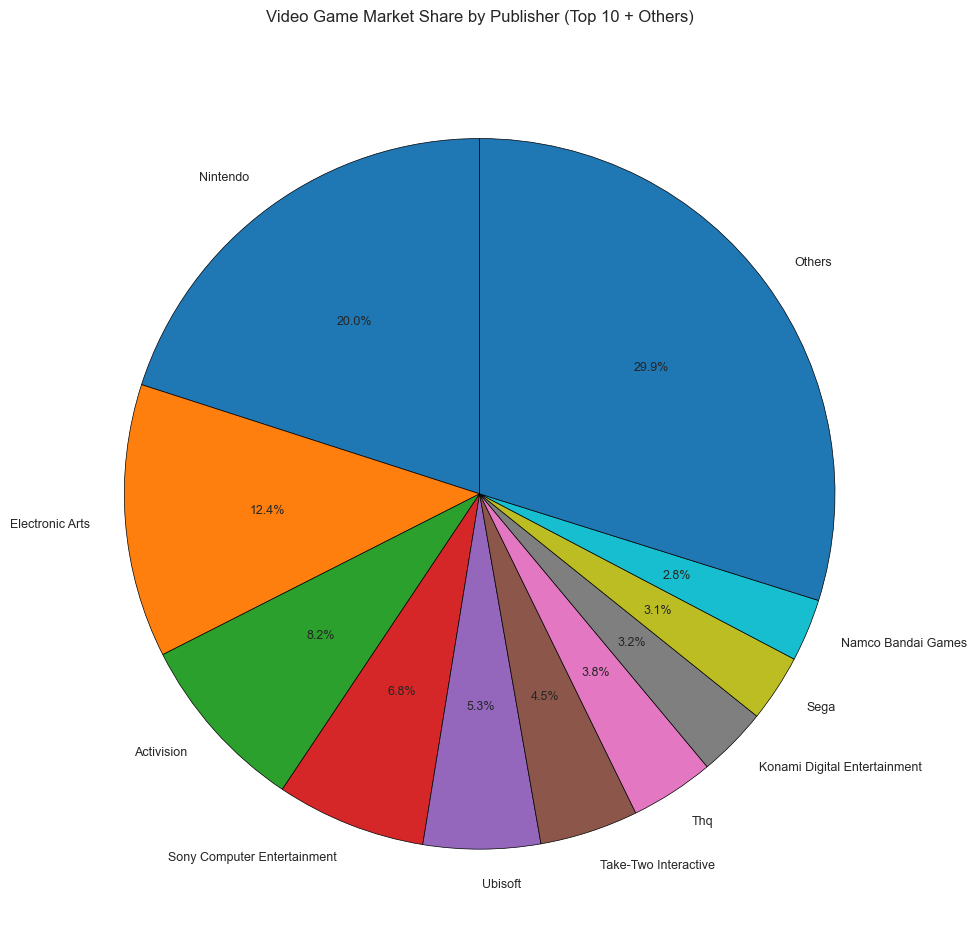

In [54]:
# Group by Publisher and sum Global_Sales
publisher_sales = df.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False)


# Select top N publishers (e.g., top 10) and group the rest as "Others"
top_n = 10
top_publishers = publisher_sales.head(top_n)
others_sales = publisher_sales[top_n:].sum()

# Combine into a final Series for the pie chart
market_share = pd.concat([top_publishers, pd.Series(others_sales, index=['Others'])])

# Plot
plt.figure(figsize=(10, 10))
plt.pie(
    market_share,
    labels=market_share.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    textprops={'fontsize': 9}
)
plt.title('Video Game Market Share by Publisher (Top 10 + Others)', pad=20)
plt.tight_layout()
plt.show()

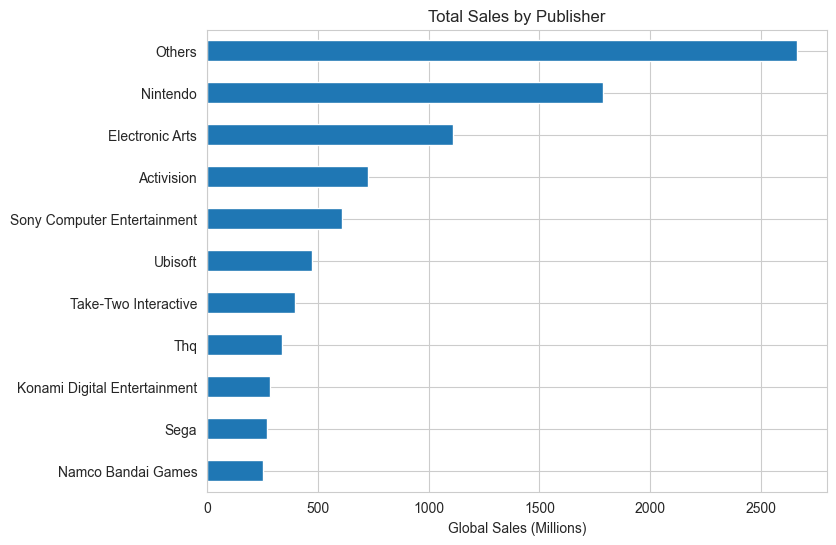

In [55]:
#Shown in a Bar Chart
market_share.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('Total Sales by Publisher')
plt.xlabel('Global Sales (Millions)')
plt.show()


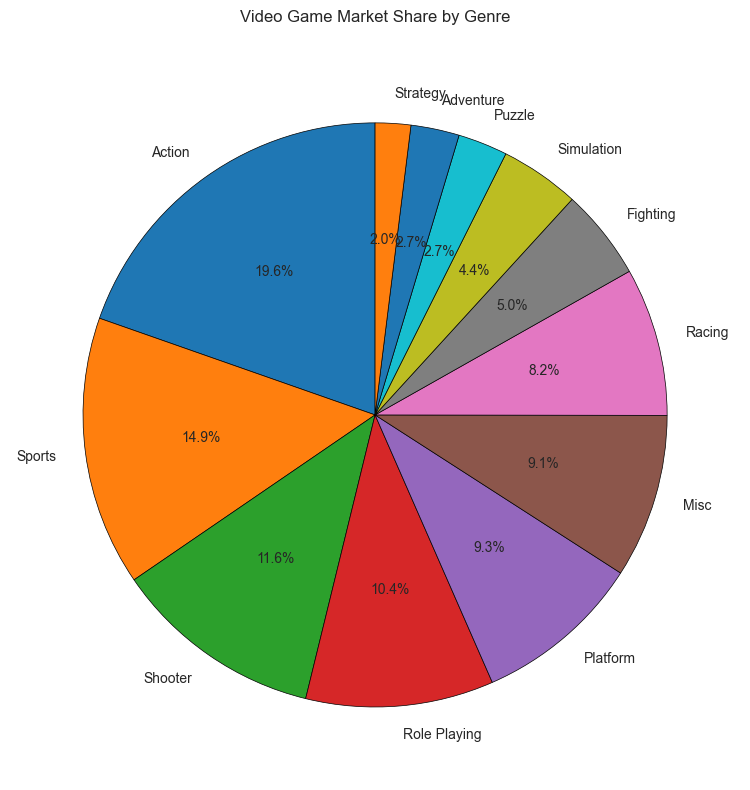

In [56]:
# Calculate total sales by genre
genre_sales = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    genre_sales,
    labels=genre_sales.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    textprops={'fontsize': 10}
)
plt.title('Video Game Market Share by Genre', pad=20)
plt.tight_layout()
plt.show()

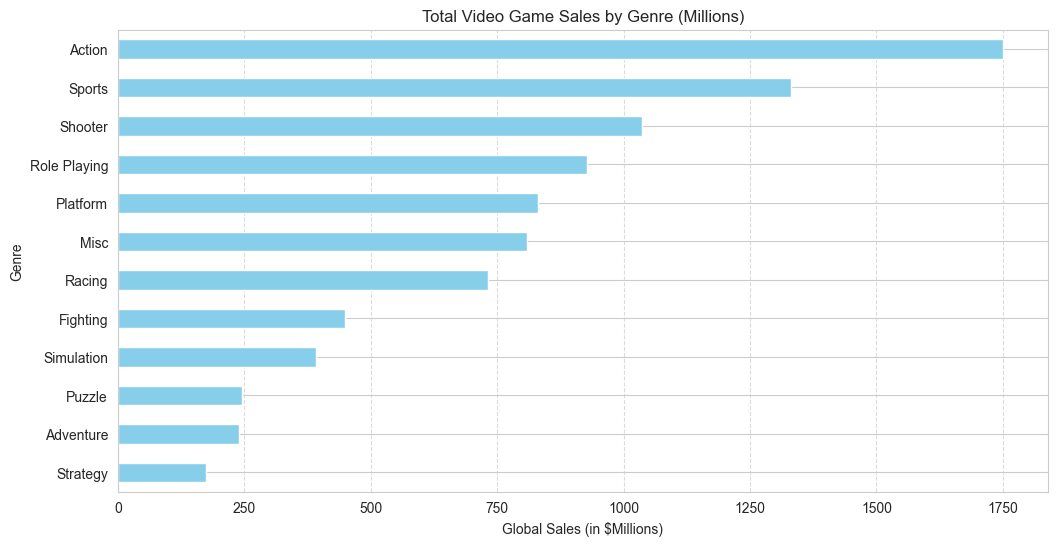

In [57]:
plt.figure(figsize=(12, 6))
genre_sales.sort_values().plot(kind='barh', color='skyblue')
plt.title('Total Video Game Sales by Genre (Millions)')
plt.xlabel('Global Sales (in $Millions)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [58]:
fig = px.bar(
    genre_sales.reset_index(),
    x='Genre',
    y='Global_Sales',
    color='Genre',
    title='Video Game Sales by Genre',
    labels={'Global_Sales': 'Total Sales (Millions)'}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

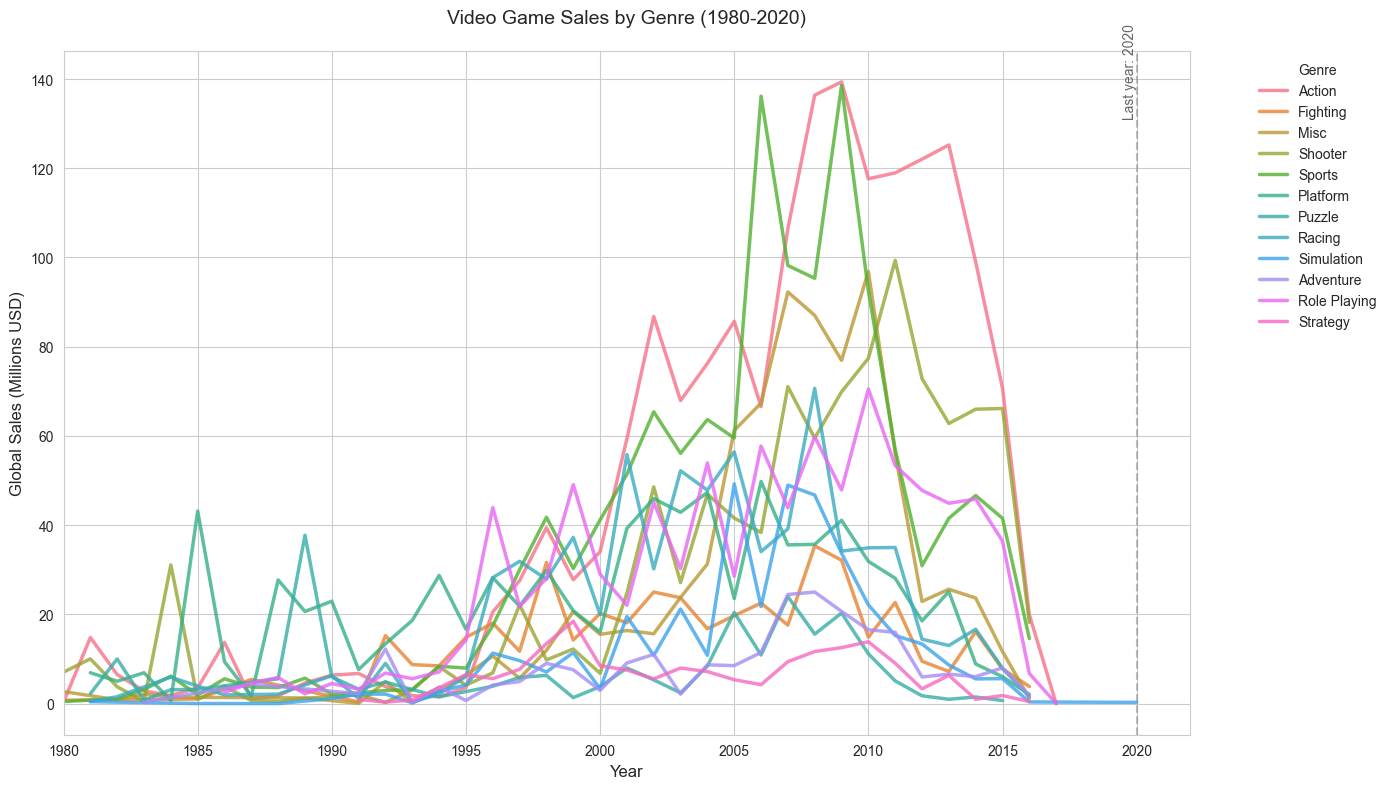

In [59]:
# Group by Year and Genre, summing sales
genre_year = df.groupby(['Year', 'Genre'])['Global_Sales'].sum().reset_index()

# Find the last valid year in the dataset
final_year = df['Year'].max()

# Filter data up to the final year
genre_year = genre_year[genre_year['Year'] <= final_year]

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

ax = sns.lineplot(
    data=genre_year,
    x='Year',
    y='Global_Sales',
    hue='Genre',
    palette='husl',  # More distinct colors
    linewidth=2.5,
    estimator=None,  # Show actual values
    alpha=0.8
)

# Customize plot
plt.title(f'Video Game Sales by Genre ({int(df["Year"].min())}-{int(final_year)})', pad=20, fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Global Sales (Millions USD)', fontsize=12)
plt.xlim(left=df['Year'].min())  # Start from first year

#legend
plt.legend(
    title='Genre',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
    fontsize=10
)

# Add vertical line at final year
plt.axvline(x=final_year, color='gray', linestyle='--', alpha=0.5)
plt.text(
    x=final_year-0.5,
    y=plt.ylim()[1]*0.9,
    s=f'Last year: {int(final_year)}',
    rotation=90,
    alpha=0.7
)

plt.tight_layout()
plt.show()

In [60]:
# Load and prepare data
df = pd.read_csv('vgsales_cleaned.csv')
df = df.dropna(subset=['Year', 'Genre', 'Platform', 'Publisher'])

# Feature engineering
df['Years_Since_Release'] = 2023 - df['Year']  # How old the game is
df['Is_Multiplayer'] = df['Name'].str.contains('Multiplayer|Online|Co-op', case=False).astype(int)

# Define features and target
X = df[['Genre', 'Platform', 'Publisher', 'Years_Since_Release', 'Is_Multiplayer']]
y = df['Global_Sales']

# Preprocessing: One-hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Genre', 'Platform', 'Publisher'])
    ],
    remainder='passthrough'
)

# Create pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model.fit(X_train, y_train)

# Evaluate
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"R² (Train): {train_score:.3f}, R² (Test): {test_score:.3f}")

R² (Train): 0.164, R² (Test): 0.089


In [61]:
# Get coefficients (importance of each feature)
encoder = model.named_steps['preprocessor'].named_transformers_['cat']
feature_names = encoder.get_feature_names_out(['Genre', 'Platform', 'Publisher'])
feature_names = np.append(feature_names, ['Years_Since_Release', 'Is_Multiplayer'])

coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.named_steps['regressor'].coef_
}).sort_values('Coefficient', ascending=False)

# Top 10 positive influences
print("Top 10 Positive Predictors of Sales:")
print(coefficients.head(10))

# Top 10 negative influences
print("\nTop 10 Negative Predictors of Sales:")
print(coefficients.tail(10))

Top 10 Positive Predictors of Sales:
                                          Feature  Coefficient
434                             Publisher_Red Orb     2.365769
379                            Publisher_Nintendo     2.089599
436                           Publisher_Redoctane     1.968844
532                         Publisher_Uep Systems     1.915176
77                  Publisher_Arena Entertainment     1.723191
557                    Publisher_Westwood Studios     1.495615
465  Publisher_Sony Computer Entertainment Europe     1.398648
344              Publisher_Microsoft Game Studios     1.062020
249                         Publisher_Hello Games     0.991104
28                                   Platform_PS4     0.886783

Top 10 Negative Predictors of Sales:
                                Feature  Coefficient
461                  Publisher_Sold Out    -0.596337
205         Publisher_Furyu Corporation    -0.625543
301  Publisher_Kokopeli Digital Studios    -0.626211
517                 


**Sports**
Trend: Decreasing
2023: 0.12M avg sales
2024: 0.10M avg sales
2025: 0.07M avg sales

**Platform**
Trend: Decreasing
2023: -0.65M avg sales
2024: -0.75M avg sales
2025: -0.85M avg sales

**Racing**
Trend: Decreasing
2023: -0.03M avg sales
2024: -0.08M avg sales
2025: -0.12M avg sales

**Role Playing**
Trend: Decreasing
2023: -0.11M avg sales
2024: -0.16M avg sales
2025: -0.20M avg sales

**Puzzle**
Trend: Decreasing
2023: -0.94M avg sales
2024: -1.02M avg sales
2025: -1.10M avg sales

**Misc**
Trend: Decreasing
2023: 0.07M avg sales
2024: 0.04M avg sales
2025: 0.02M avg sales

**Shooter**
Trend: Decreasing
2023: 0.23M avg sales
2024: 0.19M avg sales
2025: 0.16M avg sales

**Simulation**
Trend: Decreasing
2023: 0.35M avg sales
2024: 0.34M avg sales
2025: 0.33M avg sales

**Action**
Trend: Decreasing
2023: 0.16M avg sales
2024: 0.13M avg sales
2025: 0.11M avg sales

**Fighting**
Trend: Decreasing
2023: 0.06M avg sales
2024: 0.03M avg sales
2025: -0.00M avg sales

**Adventure**

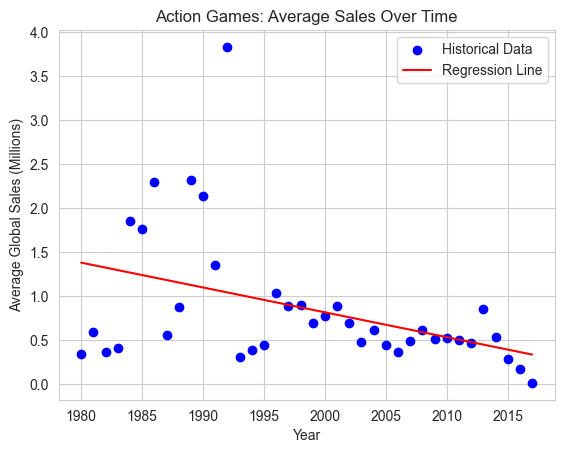

In [62]:
# Load data
df = pd.read_csv('vgsales_cleaned.csv')

# Clean and aggregate
df['Year'] = df['Year'].fillna(df['Year'].median()).astype(int)
genre_avg_sales = df.groupby(['Genre', 'Year'])['Global_Sales'].mean().reset_index()

# Function to fit linear regression and predict
def predict_genre_sales(genre, future_years=[2023, 2024, 2025]):
    genre_data = genre_avg_sales[genre_avg_sales['Genre'] == genre]
    if len(genre_data) < 2:  # Need at least 2 data points
        return None

    X = genre_data['Year'].values.reshape(-1, 1)  # Feature: Year
    y = genre_data['Global_Sales'].values          # Target: Avg Sales

    # Train model
    model = LinearRegression()
    model.fit(X, y)

    # Predict future
    future_X = np.array(future_years).reshape(-1, 1)
    future_y = model.predict(future_X)

    return {
        'genre': genre,
        'future_predictions': dict(zip(future_years, future_y)),
        'slope': model.coef_[0],  # Trend direction
        'intercept': model.intercept_
    }

# Predict for all genres
all_genres = df['Genre'].unique()
predictions = {}
for genre in all_genres:
    predictions[genre] = predict_genre_sales(genre)

# Print results
for genre, data in predictions.items():
    if data:
        print(f"\n**{genre}**")
        print(f"Trend: {'Increasing' if data['slope'] > 0 else 'Decreasing'}")
        for year, sales in data['future_predictions'].items():
            print(f"{year}: {sales:.2f}M avg sales")

# Plot example (Action games)
action_data = genre_avg_sales[genre_avg_sales['Genre'] == 'Action']
model = LinearRegression()
model.fit(action_data['Year'].values.reshape(-1, 1), action_data['Global_Sales'])

plt.scatter(action_data['Year'], action_data['Global_Sales'], color='blue', label='Historical Data')
plt.plot(action_data['Year'], model.predict(action_data['Year'].values.reshape(-1, 1)), color='red', label='Regression Line')
plt.title('Action Games: Average Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Average Global Sales (Millions)')
plt.legend()
plt.show()

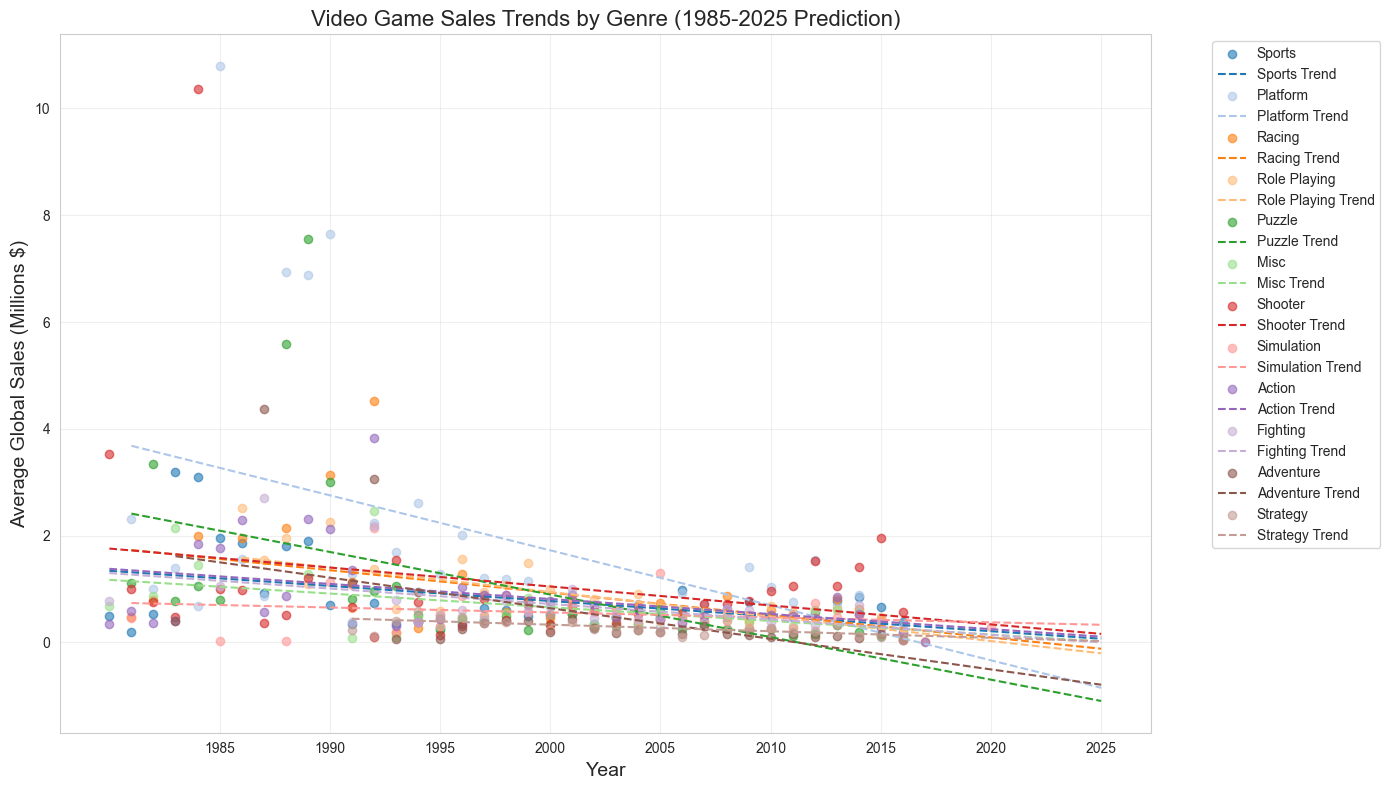

In [63]:
# Load and prepare data
df = pd.read_csv('vgsales_cleaned.csv')
df['Year'] = df['Year'].fillna(df['Year'].median()).astype(int)
genre_avg_sales = df.groupby(['Genre', 'Year'])['Global_Sales'].mean().reset_index()

# Set up plot
plt.figure(figsize=(14, 8))
colors = plt.cm.tab20.colors  # Different color for each genre

# Get unique genres and assign colors
genres = df['Genre'].unique()
color_map = {genre: colors[i % len(colors)] for i, genre in enumerate(genres)}

# Plot historical data and regression lines
for genre in genres:
    genre_data = genre_avg_sales[genre_avg_sales['Genre'] == genre]

    # Skip genres with insufficient data
    if len(genre_data) < 2:
        continue

    # Historical data (dots)
    plt.scatter(
        genre_data['Year'],
        genre_data['Global_Sales'],
        color=color_map[genre],
        label=f'{genre} (Actual)',
        alpha=0.6
    )

    # Regression line
    X = genre_data['Year'].values.reshape(-1, 1)
    y = genre_data['Global_Sales'].values
    model = LinearRegression()
    model.fit(X, y)

    # Extend line to 2025
    years_extended = np.array([X.min(), 2025]).reshape(-1, 1)
    plt.plot(
        years_extended,
        model.predict(years_extended),
        color=color_map[genre],
        linestyle='--',
        linewidth=1.5,
        label=f'{genre} Trend'
    )

# Formatting
plt.title('Video Game Sales Trends by Genre (1985-2025 Prediction)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Global Sales (Millions $)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(1985, 2026, 5))

# Smart legend (avoid overcrowding)
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = {}
for handle, label in zip(handles, labels):
    base_label = label.split(' (')[0]  # Remove "(Actual)" or "Trend"
    if base_label not in unique_labels:
        unique_labels[base_label] = handle
plt.legend(unique_labels.values(), unique_labels.keys(),
           bbox_to_anchor=(1.05, 1),
           loc='upper left')

plt.tight_layout()
plt.show()

C:\Users\farha\AppData\Local\Temp\ipykernel_21616\89869080.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\farha\AppData\Local\Temp\ipykernel_21616\89869080.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\farha\AppData\Local\Temp\ipykernel_21616\89869080.py:27: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

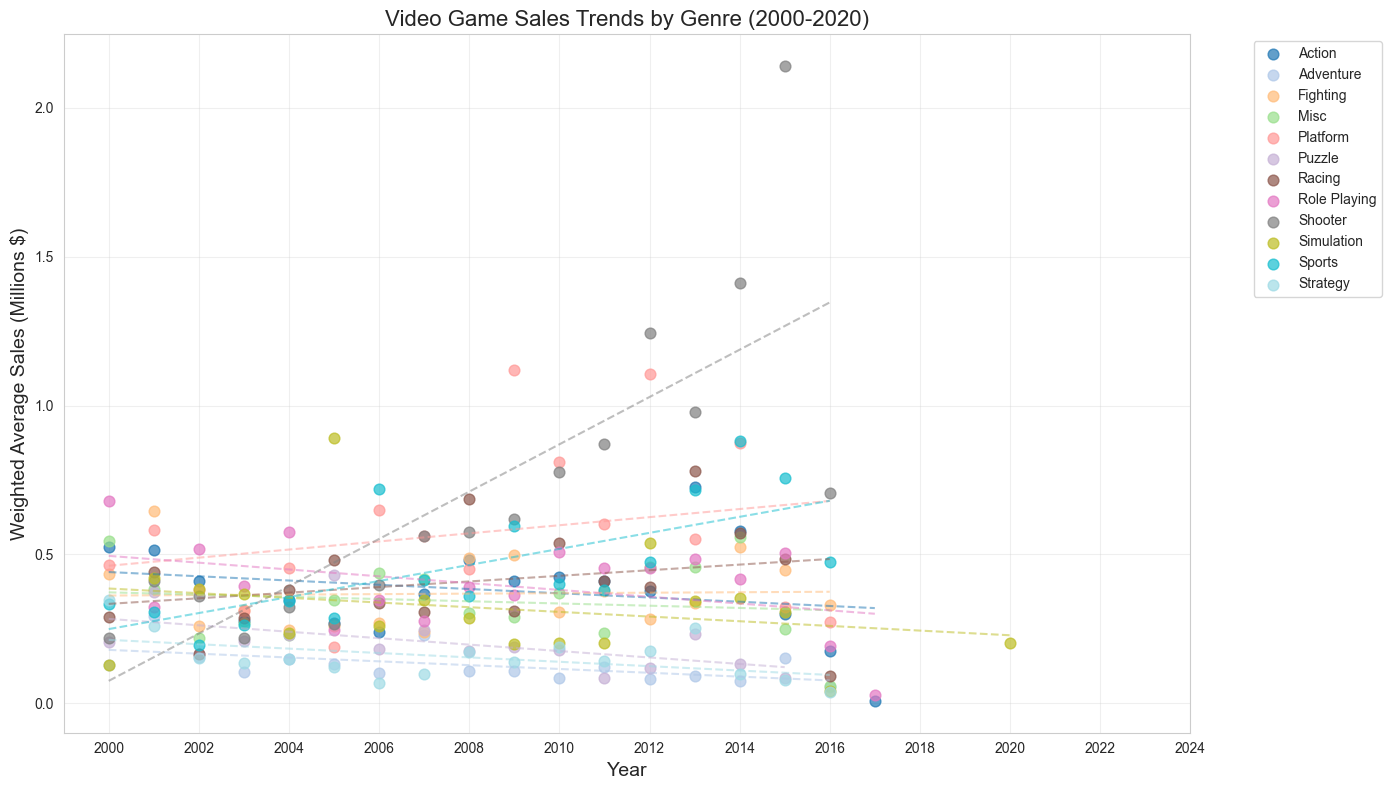

In [64]:
# Load and prepare data
df = pd.read_csv('vgsales_cleaned.csv')
df['Year'] = df['Year'].fillna(df['Year'].median()).astype(int)

# Focus on modern era (post-2000)
modern_df = df[df['Year'] >= 2000]

# Create platform weights
platform_weights = {
    'PS4': 1.5, 'XOne': 1.3, 'Switch': 1.4, 'PC': 1.2,
    'PS3': 1.0, 'X360': 1.0, 'Wii': 0.8,
    'PS2': 0.5, 'DS': 0.6, 'PSP': 0.6
}
modern_df['Platform_Weight'] = modern_df['Platform'].map(platform_weights).fillna(0.7)
modern_df['Weighted_Sales'] = modern_df['Global_Sales'] * modern_df['Platform_Weight']

# Aggregate by genre and year
genre_trends = modern_df.groupby(['Genre', 'Year']).agg({
    'Weighted_Sales': 'mean'
}).reset_index()

# Create the plot
plt.figure(figsize=(14, 8))

# Get unique genres and assign colors
genres = sorted(modern_df['Genre'].unique())
colors = cm.get_cmap('tab20', len(genres))

# Plot each genre with trend line
for i, genre in enumerate(genres):
    genre_data = genre_trends[genre_trends['Genre'] == genre]

    # Plot actual data points
    plt.scatter(
        genre_data['Year'],
        genre_data['Weighted_Sales'],
        color=colors(i),
        s=60,  # Fixed size for all points
        alpha=0.7,
        label=genre
    )

    # Add genre-specific trend line
    if len(genre_data) > 1:  # Need at least 2 points for regression
        X = genre_data['Year'].values.reshape(-1, 1)
        y = genre_data['Weighted_Sales'].values
        model = LinearRegression()
        model.fit(X, y)

        # Plot dashed trend line
        plt.plot(X, model.predict(X),
                 color=colors(i),
                 linestyle='--',
                 alpha=0.5,
                 linewidth=1.5)

# Formatting
plt.title('Video Game Sales Trends by Genre (2000-2020)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Weighted Average Sales (Millions $)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(2000, 2026, 2))

# Smart legend - one entry per genre
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = {}
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels[label] = handle
plt.legend(unique_labels.values(), unique_labels.keys(),
           bbox_to_anchor=(1.05, 1),
           loc='upper left')

plt.tight_layout()
plt.show()